In [ ]:
# Mount the Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Install the ART library (provides adversarial attacks)
!pip install adversarial-robustness-toolbox

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.5 MB/s eta 0:00:00


In [ ]:
# Import libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pickle
import pandas as pd

# Note: in this assignment we will be using the TensorFlowV2 classifier in ART
# It does not require to disable eager execution

# Print the version of tensorflow
print("TensorFlow version:{}".format(tf.__version__))

TensorFlow version:2.18.0


In [ ]:
# Download the dataset
!wget https://www.webpages.uidaho.edu/vakanski/Codes_Data/GTSRB_dataset.zip

--2025-03-07 01:12:21--  https://www.webpages.uidaho.edu/vakanski/Codes_Data/GTSRB_dataset.zip
Resolving www.webpages.uidaho.edu (www.webpages.uidaho.edu)... 129.101.105.230
Connecting to www.webpages.uidaho.edu (www.webpages.uidaho.edu)|129.101.105.230|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 123643346 (118M) [application/x-zip-compressed]
Saving to: ‘GTSRB_dataset.zip’

GTSRB_dataset.zip   100%[===================>] 117.92M  37.6MB/s    in 3.1s    

2025-03-07 01:12:24 (37.6 MB/s) - ‘GTSRB_dataset.zip’ saved [123643346/123643346]



In [ ]:
# Uncompress the dataset
!unzip -uq 'GTSRB_dataset.zip' -d 'sample_data/'

In [ ]:
# Path to the directory containing the dataset
DATA_DIR = 'sample_data/GTSRB_dataset/'

In [ ]:
# Function for loading the dataset
# Code from advml-traffic-sign (https://github.com/inspire-group/advml-traffic-sign)
def load_dataset_GTSRB(n_channel=3, train_file_name=None):
    """
    Load GTSRB data as a (datasize) x (channels) x (height) x (width) numpy
    matrix. Each pixel is rescaled to the range [0,1].
    """

    def load_pickled_data(file, columns):
        """
        Loads pickled training and test data.

        Parameters
        ----------
        file    : string
                          Name of the pickle file.
        columns : list of strings
                          List of columns in pickled data we're interested in.

        Returns
        -------
        A tuple of datasets for given columns.
        """

        with open(file, mode='rb') as f:
            dataset = pickle.load(f)
        return tuple(map(lambda c: dataset[c], columns))

    def preprocess(x, n_channel):
        """
        Preprocess dataset: turn images into grayscale if specified,
        reshape array to appropriate shape for NN model
        """

        if n_channel == 3:
            # Scale features to be in [0, 1]
            x = x.astype(np.float32)
        else:
            # Convert to grayscale, e.g. single Y channel
            x = 0.299 * x[:, :, :, 0] + 0.587 * x[:, :, :, 1] + \
                0.114 * x[:, :, :, 2]
            # Scale features to be in [0, 1]
            x = x.astype(np.float32)
            x = x[:, :, :, np.newaxis]
        return x

    # Load pickle dataset
    if train_file_name is None:
        x_train, y_train = load_pickled_data(DATA_DIR + 'train.p', ['features', 'labels'])
        x_val, y_val = load_pickled_data(DATA_DIR + 'valid.p', ['features', 'labels'])
        x_test, y_test = load_pickled_data(DATA_DIR + 'test.p', ['features', 'labels'])

    # Preprocess loaded data
    x_train = preprocess(x_train, n_channel)
    x_val = preprocess(x_val, n_channel)
    x_test = preprocess(x_test, n_channel)

    return x_train, y_train, x_val, y_val, x_test, y_test

In [ ]:
# Load the images and labels
imgs_train, labels_train, imgs_val, labels_val, imgs_test, labels_test = load_dataset_GTSRB()

In [ ]:
# Display the shapes of train, validation, and test datasets
print('Images train shape: {} - Labels train shape: {}'.format(imgs_train.shape, labels_train.shape))
print('Images validation shape: {} - Labels validation shape: {}'.format(imgs_val.shape, labels_val.shape))
print('Images test shape: {} - Labels test shape: {}'.format(imgs_test.shape, labels_test.shape))

# Display the range of images
print('\nMax pixel value', np.max(imgs_train))
print('Min pixel value', np.min(imgs_train))
print('Average pixel value', np.mean(imgs_train))
print('Data type', imgs_train[0].dtype)

Images train shape: (34799, 32, 32, 3) - Labels train shape: (34799,)
Images validation shape: (4410, 32, 32, 3) - Labels validation shape: (4410,)
Images test shape: (12630, 32, 32, 3) - Labels test shape: (12630,)

Max pixel value 255.0
Min pixel value 0.0
Average pixel value 82.67778
Data type float32


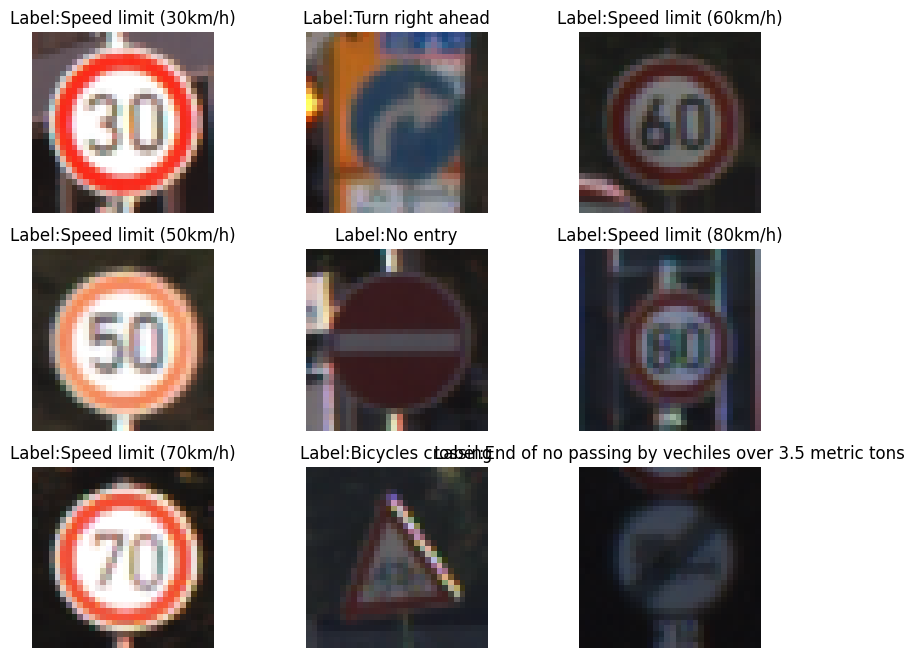

In [ ]:
# Read the sign names
label_names = pd.read_csv('sample_data/GTSRB_dataset/signnames.csv').values[:, 1]

# Plot a few images to check if the data makes sense (note that the quality of some of the images is pretty low)
plt.figure(figsize=(10, 8))
for n in range(9):
    i = np.random.randint(0, len(imgs_train), 1)
    ax = plt.subplot(3, 3, n+1)
    plt.imshow(imgs_train[i[0]].astype(np.uint8))
    plt.title('Label:' + str(label_names[labels_train[i[0]]]))
    plt.axis('off')

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50

import datetime
now = datetime.datetime.now

# Train a ResNet-50 convolutional neural network for classification of the traffic signs in the dataset using the TensorFlow library.

In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# Add a fully-connected layer
x = Dense(2048, activation='relu')(x)
x = Dropout(0.25)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.25)(x)
# Add a softmax layer with 43 classes
predictions = Dense(43, activation='softmax')(x)

# The model
model = Model(inputs=base_model.input, outputs=predictions)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [EarlyStopping(monitor='val_loss', patience=3)]

# Train the model
t = now()
history = model.fit(imgs_train, labels_train, epochs=100, batch_size=64,
                    validation_data=(imgs_val, labels_val), verbose=1, callbacks=callbacks)
print('\nTraining time: %s' % (now() - t))

Epoch 1/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 114s 94ms/step - accuracy: 0.4305 - loss: 2.2114 - val_accuracy: 0.7490 - val_loss: 1.0260
Epoch 2/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 30s 41ms/step - accuracy: 0.9394 - loss: 0.2001 - val_accuracy: 0.8166 - val_loss: 0.8851
Epoch 3/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.9808 - loss: 0.0652 - val_accuracy: 0.8481 - val_loss: 0.8113
Epoch 4/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 41s 41ms/step - accuracy: 0.9879 - loss: 0.0431 - val_accuracy: 0.8571 - val_loss: 0.7835
Epoch 5/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 40s 40ms/step - accuracy: 0.9898 - loss: 0.0371 - val_accuracy: 0.8735 - val_loss: 0.6961
Epoch 6/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - accuracy: 0.9911 - loss: 0.0328 - val_accuracy: 0.8667 - val_loss: 0.6915
Epoch 7/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 41s 39ms/step - accuracy: 0.9926 - loss: 0.0310 - val_accuracy: 0.9190 - val_loss: 0.3882
Epoch 8/100
544/544 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - accuracy: 0.9945 - loss: 

# Plot the training and validation loss and accuracy curves.

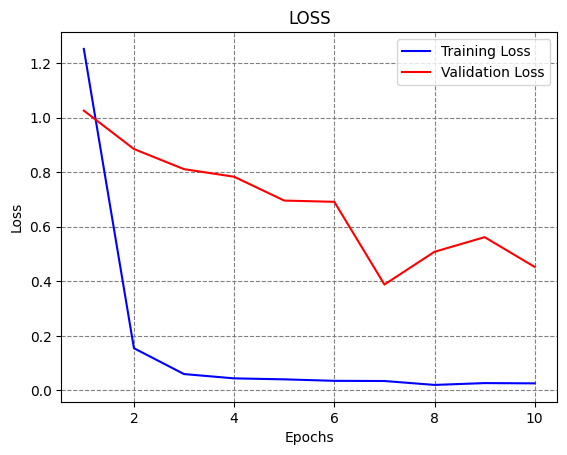

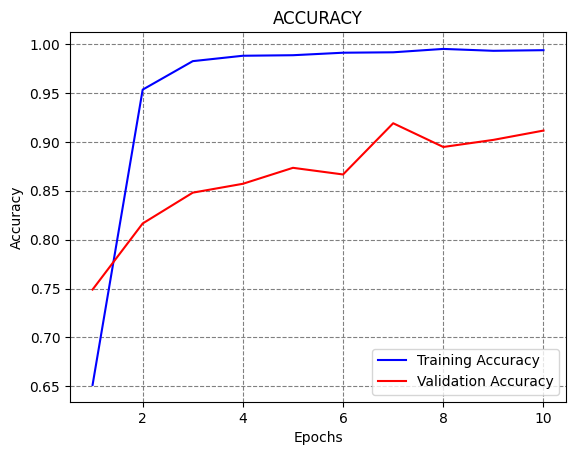

In [ ]:
# Plot the loss and accuracy
train_loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochsn = np.arange(1, len(train_loss)+1,1)
plt.plot(epochsn,train_loss, 'b', label='Training Loss')
plt.plot(epochsn,val_loss, 'r', label='Validation Loss')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('LOSS')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.figure()
plt.plot(epochsn, acc, 'b', label='Training Accuracy')
plt.plot(epochsn, val_acc, 'r', label='Validation Accuracy')
plt.grid(color='gray', linestyle='--')
plt.legend()
plt.title('ACCURACY')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

# Perform hyperparameter tuning to obtain accuracy on the test dataset above 90%.

In [ ]:
# Evaluate on test images
evals_test = model.evaluate(imgs_test, labels_test)
print("Classification Accuracy: ", evals_test[1])

395/395 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - accuracy: 0.9147 - loss: 0.4558
Classification Accuracy:  0.911163866519928


In [ ]:
# Evaluate on training images
evals_train = model.evaluate(imgs_train, labels_train)
print("Training Classification Accuracy:", evals_train[1])

# Evaluate on validation images
evals_val = model.evaluate(imgs_val, labels_val)
print("Validation Classification Accuracy:", evals_val[1])


1088/1088 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - accuracy: 0.9990 - loss: 0.0058
Training Classification Accuracy: 0.9989942312240601
138/138 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - accuracy: 0.8675 - loss: 0.6961
Validation Classification Accuracy: 0.9115646481513977


# Implement an untargeted boundary attack against the trained model using the TensorFlowV2Classifier in the ART library.

In [ ]:
from art.estimators.classification import TensorFlowV2Classifier
from art.attacks.evasion import BoundaryAttack

In [ ]:
# In this assigment we will use TensorFlowV2Classifier
# It requires to specify the number of classes, input shape, and values of the inputs
classifier = TensorFlowV2Classifier(model=model, nb_classes=43, input_shape=(32, 32, 3), clip_values=(0, 255))

The true class of the target image is: Stop
The predicted class of the target image is:  Stop


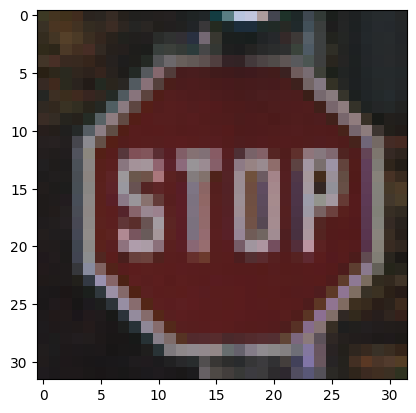

In [ ]:
# Let's use the first test images to create an adversarial example
# Plot the image and display the true and predicted class
target_image = imgs_test[111].astype(np.uint8)
print('The true class of the target image is: ' + label_names[labels_test[111]])
print("The predicted class of the target image is: ", label_names[np.argmax(classifier.predict([target_image]))])
plt.imshow(target_image)
plt.show()

# Print the L2 norm and the label of the adversarial image for each step of the attack

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations: 0it [00:00, ?it/s]

Adversarial image at step 0. L2 error 5965.4854 and class label 2.
The label is Speed limit (50km/h)


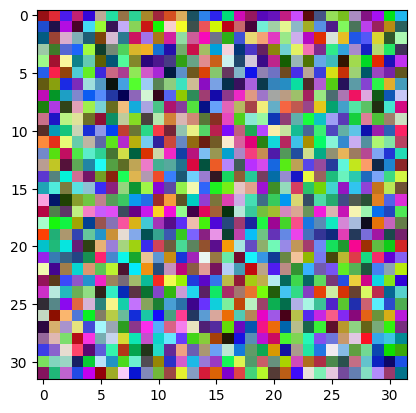

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 200. L2 error 426.3137 and class label 2.
The label is Speed limit (50km/h)


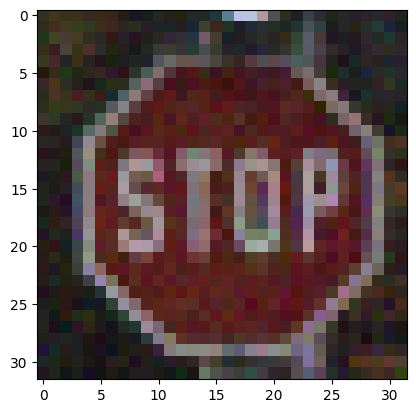

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 400. L2 error 298.38315 and class label 2.
The label is Speed limit (50km/h)


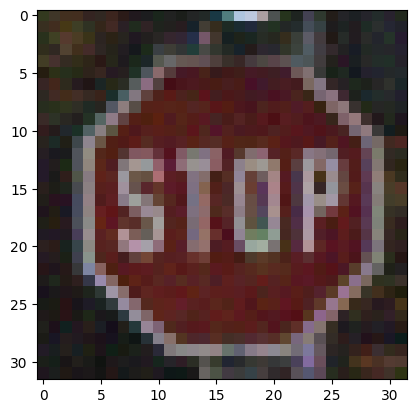

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 600. L2 error 253.7161 and class label 2.
The label is Speed limit (50km/h)


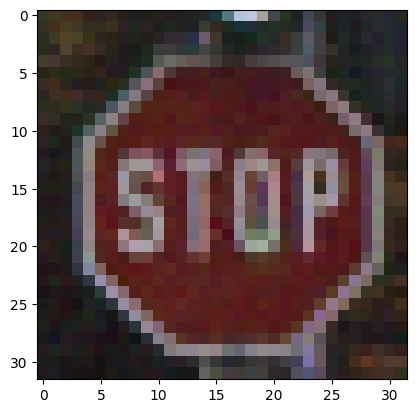

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 800. L2 error 225.97884 and class label 2.
The label is Speed limit (50km/h)


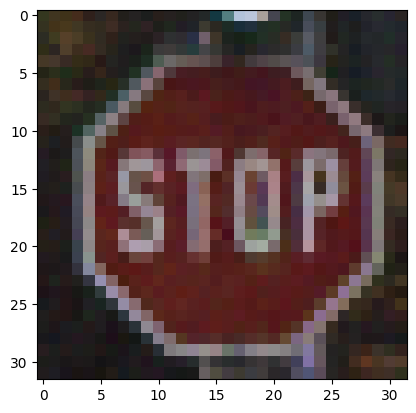

Attack time: 0:07:24.716582


In [ ]:
t = now()

attack = BoundaryAttack(estimator=classifier, targeted=False, max_iter=0, delta=0.5, epsilon=0.3)
iter_step = 200
x_adv = None
for i in range(5):
    x_adv = attack.generate(x=np.array([target_image]), x_adv_init=x_adv)
    # print the norm of the perturbation and show the perturbed image
    print("Adversarial image at step %d." % (i * iter_step), "L2 error",
          np.linalg.norm(np.reshape(x_adv[0] - target_image, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    print('The label is', label_names[np.argmax(classifier.predict(x_adv)[0])])
    plt.imshow(x_adv[0].astype(np.uint8))
    plt.show(block=False)

    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break

print('Attack time: %s' % (now() - t))

# Plot the final adversarial image with the predicted label by the classifier

The predicted class of the target image is:  Speed limit (50km/h)


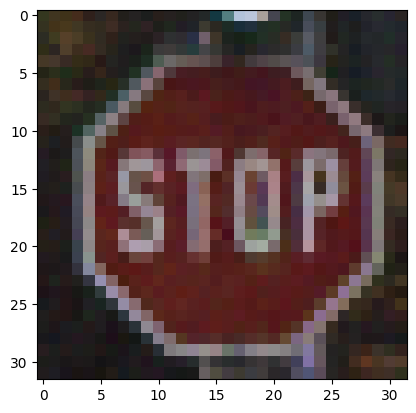

In [ ]:
print("The predicted class of the target image is: ", label_names[np.argmax(classifier.predict(x_adv))])
plt.imshow(x_adv[0].astype(np.uint8))
plt.show()

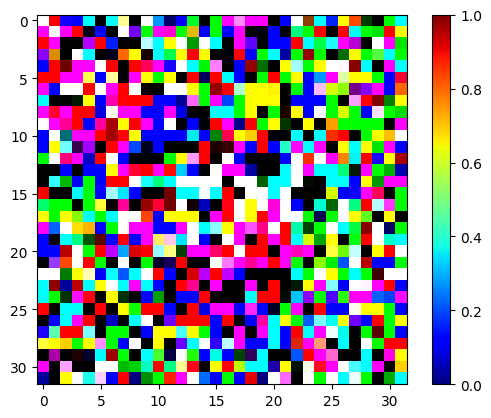

In [ ]:
# Show the difference between the perturbed and clean image
plt.imshow(target_image-x_adv[0], cmap='jet')
plt.colorbar()
plt.show()

###Implement a targeted boundary attack against the trained model using the TensorFlowV2Classifier in the ART library.

Select the Stop Sign image with index 111 from the test dataset to be used for creating an
adversarial sample.

The true class of the target image is: Stop
The predicted class of the target image is:  Stop


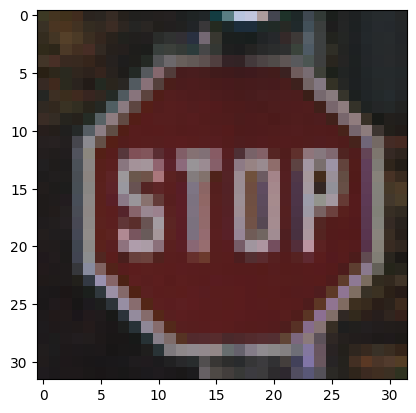

In [ ]:
# Select a target image to create an adversarial example
target_image = imgs_test[111].astype(float)
print('The true class of the target image is: ' + label_names[labels_test[111]])
print("The predicted class of the target image is: ", label_names[np.argmax(classifier.predict([target_image]))])
plt.imshow(target_image.astype(np.uint8))
plt.show()

Select the Speed Limit (80km/h) image with index 217 from the test dataset with the target class label. Plot the image with the ground truth label and the predicted label by the DL model

The true class of the initial image is: Speed limit (80km/h)
The predicted class of the initial image is:  Speed limit (80km/h)


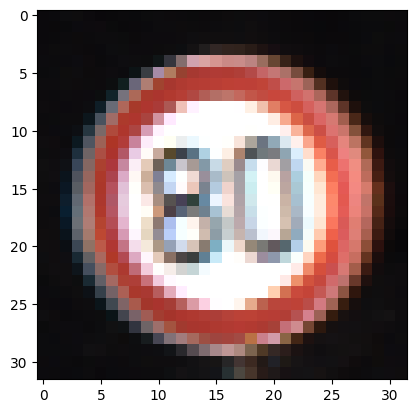

In [ ]:
# Select one image from the target class as initial image
init_image = imgs_test[217]
print('The true class of the initial image is: ' + label_names[labels_test[217]])
print("The predicted class of the initial image is: ", label_names[np.argmax(classifier.predict(np.expand_dims(init_image, axis=0)))])
plt.imshow(init_image.astype(np.uint8))
plt.show()

In [ ]:
# Check the class label of the initial image
print("Init image is: ", np.argmax(classifier.predict(np.array([init_image]))[0]))

Init image is:  5


Using the boundary attack, create an adversarial image that will change the label of the
selected image to the target label Speed Limit (80km/h)

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations: 0it [00:00, ?it/s]

Adversarial image at step 0. L2 error 4945.748477227688 and class label 5.
The label is Speed limit (80km/h)


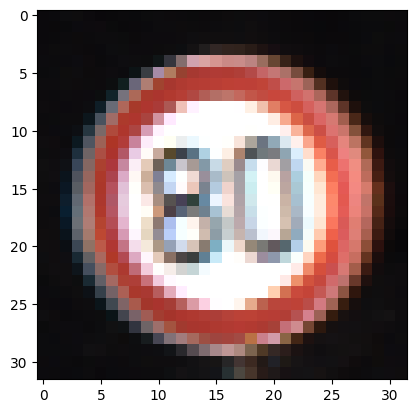

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 200. L2 error 650.4681473410511 and class label 5.
The label is Speed limit (80km/h)


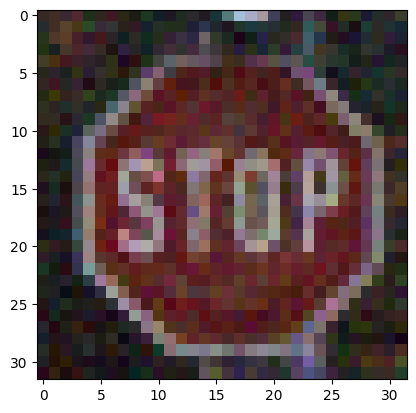

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 400. L2 error 408.48590460275176 and class label 5.
The label is Speed limit (80km/h)


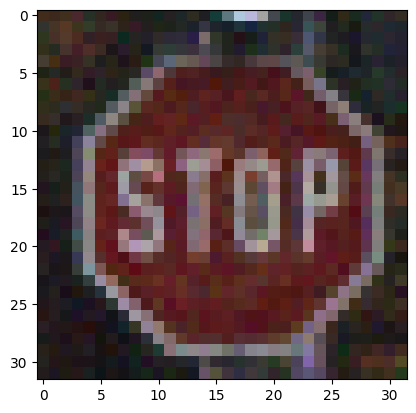

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 600. L2 error 326.79078728938237 and class label 5.
The label is Speed limit (80km/h)


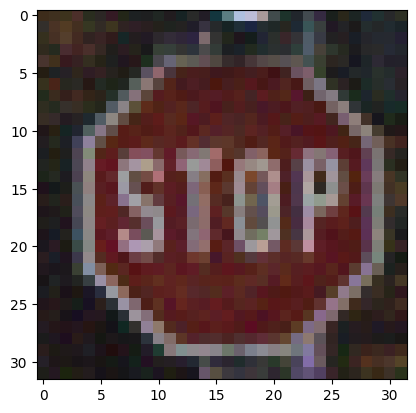

Boundary attack:   0%|          | 0/1 [00:00<?, ?it/s]

Boundary attack - iterations:   0%|          | 0/200 [00:00<?, ?it/s]

Adversarial image at step 800. L2 error 287.96325928091744 and class label 5.
The label is Speed limit (80km/h)


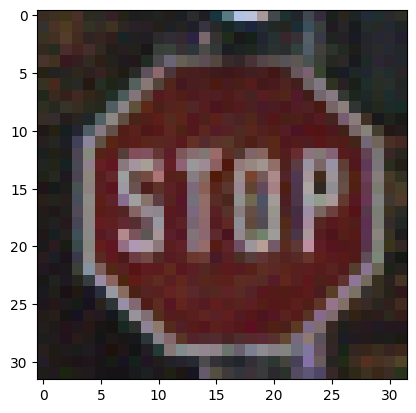

Attack time: 0:14:45.606854


In [ ]:
from tensorflow.keras.utils import to_categorical

attack = BoundaryAttack(estimator=classifier, targeted=True, max_iter=0, delta=0.5, epsilon=0.3)
iter_step = 200
x_adv = np.expand_dims(init_image, axis=0)

for i in range(5):
    x_adv = attack.generate(x=np.expand_dims(target_image, axis=0), y=to_categorical([5], 43), x_adv_init=x_adv)

    # print the norm of the perturbation and show the perturbed image
    print("Adversarial image at step %d." % (i * iter_step), "L2 error",
          np.linalg.norm(np.reshape(x_adv[0] - target_image, [-1])),
          "and class label %d." % np.argmax(classifier.predict(x_adv)[0]))
    print('The label is', label_names[np.argmax(classifier.predict(x_adv)[0])])
    plt.imshow(x_adv[0].astype(np.uint8))
    plt.show(block=False)

    if hasattr(attack, 'curr_delta') and hasattr(attack, 'curr_epsilon'):
        attack.max_iter = iter_step
        attack.delta = attack.curr_delta
        attack.epsilon = attack.curr_epsilon
    else:
        break

print('Attack time: %s' % (now() - t))

Plot the adversarial image with the predicted label by the classifier.

The predicted class of the target image is:  Speed limit (80km/h)


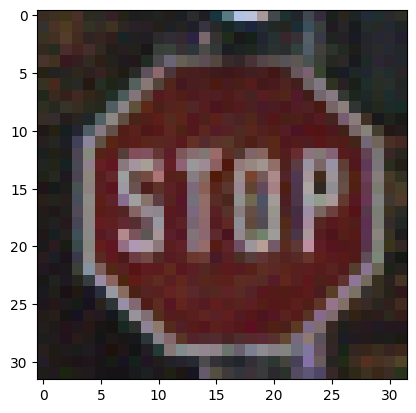

In [ ]:
print("The predicted class of the target image is: ", label_names[np.argmax(classifier.predict(x_adv))])
plt.imshow(x_adv[0].astype(int))
plt.show()

#                               END OF **PART ONE**